In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
sys.path.append('../')

from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, recall_score, precision_score

from preprocessing.getdata import *

In [2]:
df_preds = pd.read_csv("CNN_predictions.csv")
df_preds.rename(columns= {"pred":"cnn_prob"}, inplace = True)


In [3]:
y_probs = df_preds['cnn_prob']
df_preds["cnn_pred"] = y_probs.round()
y_pred = y_probs.round()
y_test = df_preds['y_test']

accuracy:  0.77
recall:  0.97
precision:  0.72


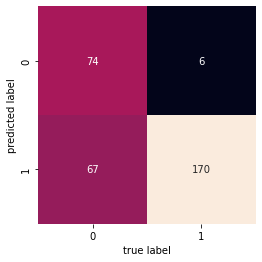

In [4]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred).round(2))
print('recall: ' , recall_score(y_test, y_pred).round(2))
print('precision: ' , precision_score(y_test, y_pred).round(2))

In [5]:
#Loading the original dataframes
df_a = get_csvdata_ADNI(False)
df_o = get_csvdata_OASIS(False, False)
df_oa = pd.concat([df_o, df_a])

In [6]:
#merging with CNN modelling results 
df_result = df_preds.merge(df_oa, on='ID', how='left')

In [7]:
def classification(row):
    if (row.y_test == 1) & (row.cnn_pred == 1):
        return "TP"
    if (row.y_test == 0) & (row.cnn_pred == 1):
        return "FP"
    if (row.y_test == 0) & (row.cnn_pred == 0):
        return "TN"
    if (row.y_test == 1) & (row.cnn_pred == 0):
        return "FN"

df_result["classification"] = df_result.apply(lambda row: classification(row), axis=1)

[Text(0, 0.5, 'CN'), Text(0, 1.5, 'MCI/AD')]

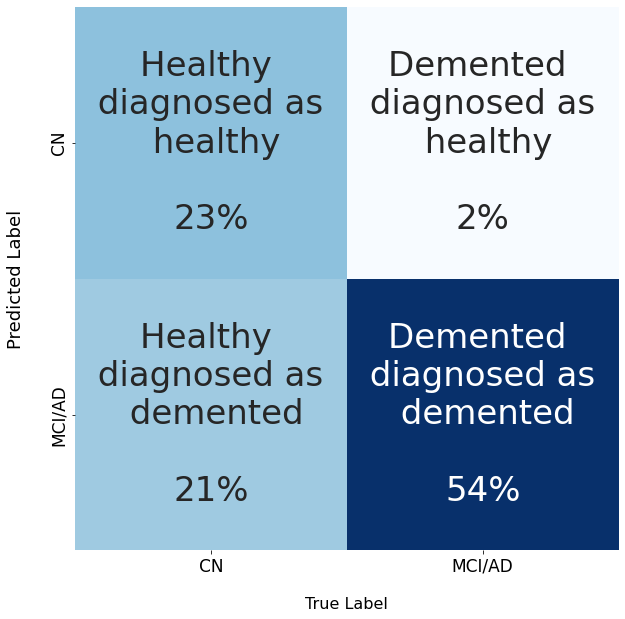

In [8]:
mat = confusion_matrix(df_result.y_test, df_result.cnn_pred.round())
group_names = ["Healthy \n diagnosed as \n healthy\n ","Demented \n diagnosed as \n healthy\n ","Healthy \n diagnosed as \n demented\n ","Demented \n diagnosed as \n demented\n "]
group_percentages = ["{0:.0%}".format(value) for value in
                     mat.flatten()/np.sum(mat)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,[group_percentages[0], group_percentages[2], group_percentages[1],group_percentages[3]])]
labels = np.asarray(labels).reshape(2,2)
#labels = np.asarray(group_names).reshape(2,2)



ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(mat.T/317, square=True, annot=labels, fmt='', cbar=False, cmap="Blues", annot_kws={"size":34})

plt.xlabel(' \nTrue Label', fontsize=16)
plt.ylabel('Predicted Label\n ', fontsize=18)
ax.set_xticklabels(["CN", "MCI/AD"], size=17)
ax.set_yticklabels(["CN", "MCI/AD"], size=17)

[Text(0, 0.5, 'CN'), Text(0, 1.5, 'MCI/AD')]

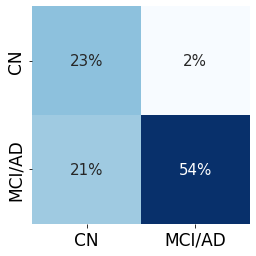

In [9]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(group_names).reshape(2,2)

mat = confusion_matrix(df_result.y_test, df_result.cnn_pred.round())
ax = sns.heatmap(mat.T/317, square=True, annot=True, fmt='.0%', cbar=False, cmap="Blues", annot_kws={"size":15})
#plt.xlabel(' \nTrue Label', fontsize=15)
#plt.ylabel('Predicted Label\n ', fontsize=15)
ax.set_xticklabels(["CN", "MCI/AD"], size=17)
ax.set_yticklabels(["CN", "MCI/AD"], size=17)

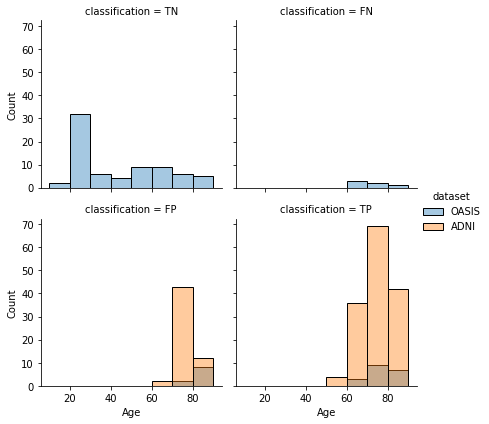

In [10]:
plot= sns.FacetGrid(data=df_result, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"], hue="dataset", legend_out=True)
plot.map_dataframe(sns.histplot, x="Age", binrange=(10,90), binwidth=10, alpha=0.4)
plot.add_legend();

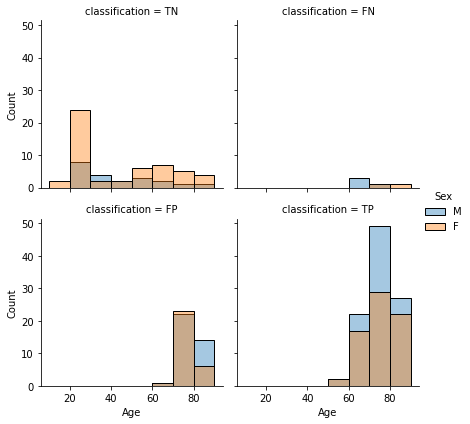

In [11]:
plot= sns.FacetGrid(data=df_result, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"], hue="Sex", legend_out=True)
plot.map_dataframe(sns.histplot, x="Age", binrange=(10,90), binwidth=10, alpha=0.4)
plot.add_legend();

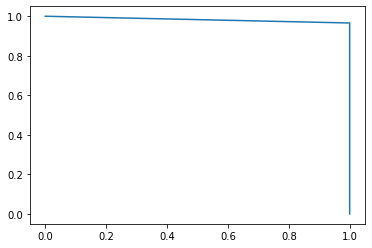

In [12]:
precision, recall, thresholds = precision_recall_curve(df_result["y_test"], df_result["cnn_pred"])
thresholds = np.append(thresholds, 1)
plt.plot(thresholds, recall)

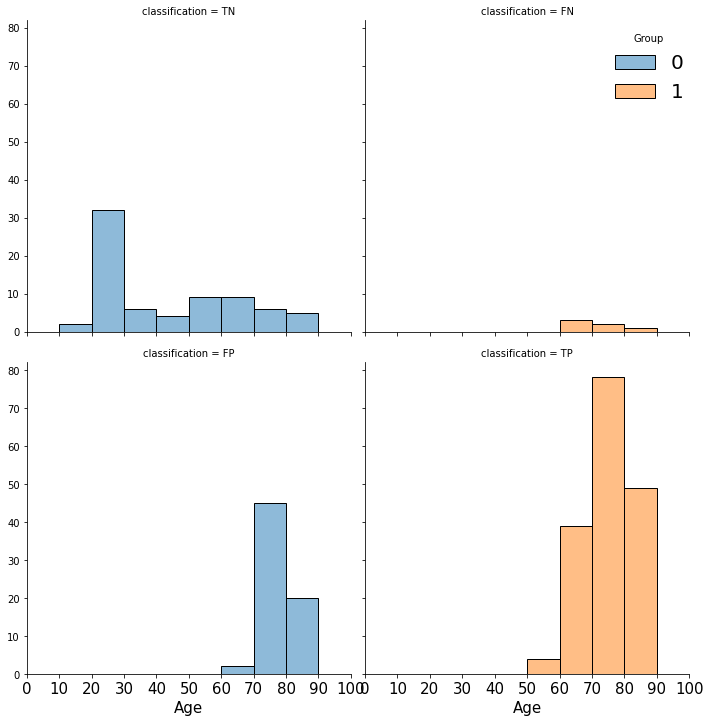

In [13]:
plot= sns.FacetGrid(data=df_result, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"], hue="label", legend_out=True, height=5)
plot.map_dataframe(sns.histplot, x="Age", binrange=(10,90), binwidth=10, alpha=0.5)
plot.add_legend(fontsize=20, title= "Group", bbox_to_anchor= (0.9,0.9))
plot.set_xticklabels(fontsize=15)
plot.set_ylabels(fontsize=15)
plot.set_xlabels(fontsize=15)

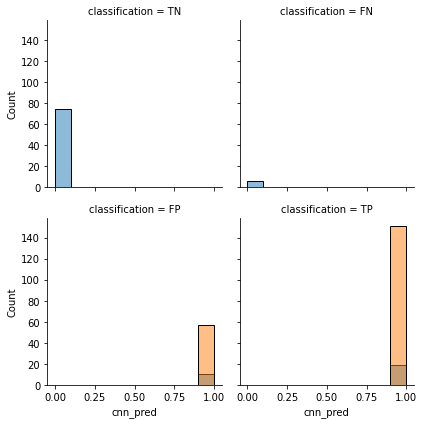

In [14]:
plot= sns.FacetGrid(data=df_result, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"], hue="dataset", legend_out=True)
plot.map_dataframe(sns.histplot, x="cnn_pred", binrange=(0,1), binwidth=0.1, alpha=0.5);

In [15]:
# adding new column that contains the order of predictions probabilities
df = df_result.copy()
df["orig_order"] = df.index
df.sort_values("cnn_pred", inplace=True)
df= df.reset_index(drop=True)
df["order"] = df.index
df.sort_values("orig_order", inplace=True)
df= df.reset_index(drop=True)
df.drop("orig_order", axis=1, inplace=True)

In [16]:
#loading the images

os.chdir('../')
IDs_o = df[df["dataset"]== "OASIS"]["ID"]
IDs_a = df[df["dataset"]== "ADNI"]["ID"]

imgs = get_slices_both(OASIS_IDs =IDs_o, ADNI_IDs =IDs_a, dim=2, m=90, normalize=True)
imgs.shape

100%|██████████| 208/208 [00:31<00:00,  6.62it/s]


(317, 176, 208)

In [17]:
#sortin the image array by the prediction order
order= np.array(df["order"])
sort = order.argsort()
imgs_sorted= imgs[sort]

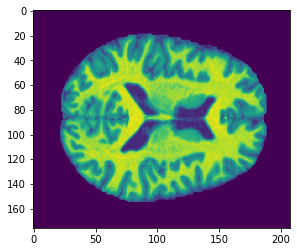

In [18]:
#most confident CN
plt.imshow(imgs_sorted[0])

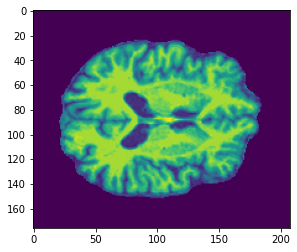

In [19]:
#most confident AD
im = plt.imshow(imgs_sorted[-1])

In [20]:
from matplotlib import animation


# generating gif out of slices of 3-dimensional numpy array
def generate_gif(numpy_3d_array, y_pred, path="test.gif"):
    fig = plt.figure()
    im = plt.imshow(numpy_3d_array[0, :, :],    # display first slice
                    animated=True,
                    cmap='Greys',               # color mapping
                    vmin=0, # lowest value in numpy_3d_array
                    vmax=1) # highest value in numpy_3d_array
    

    def init():
        im.set_data(numpy_3d_array[0, :, :])
        return im,

    def animate(i):
        im.set_array(numpy_3d_array[i, :, :])
        #plt.text(180,20, y_pred[i], fontsize=20)
        return im,

    # calling animation function of matplotlib
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=np.shape(numpy_3d_array)[0],  # amount of frames being animated
                                   interval=100,                       # update every x-milliseconds
                                   blit=True)
    anim.save(path)   # save as gif
    plt.show()

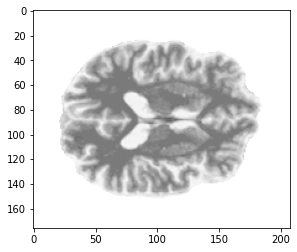

In [21]:
#saving the images sorted by the probabilities as a gif
os.makedirs("./gifs/", exist_ok=True)
generate_gif(imgs_sorted, y_pred=df["cnn_pred"], path="./gifs/final_model.gif")

## Ensemble voting with predictions from the numerical model

In [23]:
#loading results of numerical modelling
df_num = pd.read_csv("./modelling/num_predictions.csv")
df_num.shape

(204, 15)

In [24]:
# merge for ensemble with numerical model
df_ens = df.merge(df_num, on="ID", how="inner")
df_ens.head()

,Unnamed: 0,ID,cnn_prob,y_test,cnn_pred,Sex_x,Age_x,Educ,SES,MMSE_x,...,Entorhinal,MMSE_y,Imputed,Sex_y,label_y,Train,y_test_num,y_pred_num,probs1_num,classification_y
0,109,114_S_0416,0.819678,0,1.0,F,73,NaN,NaN,NaN,...,3707.0,29.0,0.0,F,0,False,0,1,0.772789,FP
1,110,023_S_1247,0.805396,1,1.0,F,73,NaN,NaN,NaN,...,3339.0,24.0,0.0,F,1,False,1,1,0.721020,TP
2,111,128_S_1088,0.793949,1,1.0,M,88,NaN,NaN,NaN,...,3317.0,24.0,0.0,M,1,False,1,1,0.549180,TP
3,112,126_S_0784,0.746684,1,1.0,F,76,NaN,NaN,NaN,...,3651.6,23.0,1.0,F,1,False,1,1,0.707992,TP
4,113,141_S_0697,0.815408,1,1.0,M,87,NaN,NaN,NaN,...,3577.4,26.0,1.0,M,1,False,1,1,0.623381,TP


In [25]:
# ensemble soft voting and rounding to get predictions
df_ens["ensemble"] = (df_ens["cnn_prob"] + df_ens["probs1_num"]) / 2
df_ens["ens_pred"] = (df_ens["ensemble"]).round()
df_ens["cnn_pred"] = (df_ens["cnn_prob"]).round()

In [26]:
#check how many predictions changed by the ensemble voting
df_ens[df_ens["ens_pred"] != df_ens["cnn_pred"]]

,Unnamed: 0,ID,cnn_prob,y_test,cnn_pred,Sex_x,Age_x,Educ,SES,MMSE_x,...,Imputed,Sex_y,label_y,Train,y_test_num,y_pred_num,probs1_num,classification_y,ensemble,ens_pred


In [27]:
# before ensemble
print(confusion_matrix(df_ens["y_test"], df_ens["cnn_pred"]))
print(accuracy_score(df_ens["y_test"], df_ens["cnn_pred"]))
print(recall_score(df_ens["y_test"], df_ens["cnn_pred"]))
print(precision_score(df_ens["y_test"], df_ens["cnn_pred"]))

[[  0  57]
 [  0 147]]
0.7205882352941176
1.0
0.7205882352941176


In [28]:
#after ensemble
print(confusion_matrix(df_ens["y_test"], df_ens["ens_pred"]))
print(accuracy_score(df_ens["y_test"], df_ens["ens_pred"]))
print(recall_score(df_ens["y_test"], df_ens["ens_pred"]))
print(precision_score(df_ens["y_test"], df_ens["ens_pred"]))

[[  0  57]
 [  0 147]]
0.7205882352941176
1.0
0.7205882352941176
